In [1]:
import awkward as ak
import numpy as np
import time
# print(coffea.__version__)
from coffea import util
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema
import mplhep as hep

In [2]:
from plugins import handleData
redirector = 'root://xcache/'
# files = handleData('fileset_QCD.json', redirector, year = 2018, testing = True, data = False)
# events = NanoEventsFactory.from_root(list(files.values())[0][0], schemaclass=NanoAODSchema).events()
file = 'root://xcache//store/data/Run2018A/JetHT/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v2/100000/00AA9A90-57AA-D147-B4FA-54D6D8DA0D4A.root'
#file = "root://xcache//store/mc/RunIISummer20UL18NanoAODv9/QCD_Pt_470to600_TuneCP5_13TeV_pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/130000/04101AE0-F4F7-364B-9089-BEE9156A0C69.root"
events = NanoEventsFactory.from_root(file, schemaclass=NanoAODSchema).events()

In [11]:
from scipy.optimize import minimize, curve_fit
from scipy.stats import rv_continuous
from scipy.special import erf, erfinv

def fit_function(x, b, c):
    y = 0.5*(1+erf((x-b)/c))
    return y


def negLL(params, x, data):
    #x is the pt bin centers, y is the fit
    y = fit_function(x, *params)
    negLL = -np.sum(-(data-y)**2/2)
    return negLL
                      
                      
def fit_trigEff(x, data):
    #x is the pt bin centers; data is the efficiency values
    bounds = ((50., 500.), (50., 500.))
    x0 = [200., 200.]
    popt, pcov = curve_fit(fit_function, x, data, p0 = x0)
    result = minimize(negLL, x0 = popt, args= (x, data), bounds = bounds)
    print("Basic fit results: ", popt)
    print("MLE results: ", result.get("jac"))
    return result.get("jac"), popt

import matplotlib.pyplot as plt
plt.style.use([hep.style.CMS, hep.style.firamath])
from coffea import hist  
from plugins import checkdir
def plot_turnOn(result, HLT):
    hist_trigEff_ptCut = result['hist_trigEff_ptCut']
    hist_trigEff = result['hist_trigEff']
    hist_trigRef = result['hist_trigRef']
    hist_pt = result['hist_pt']
    HLT_paths = [path[0] for path in list(hist_trigEff.sum('dataset').values())]
    dataset = list(hist_trigEff.sum('pt').sum('HLT_cat').values().keys())[0][0]
    os_path = 'plots/triggerStudies'+ dataset + 'Testing/'
    checkdir(os_path)
    print('HLT_paths:', HLT_paths)
    trigThresh = [int(path.replace(HLT, '')) for path in HLT_paths]
    turnOnPts = {}
    turnOnPts_ptCut = {}
    for i in np.arange(len(HLT_paths)):
        path = HLT_paths[i]
        print("Path = ", path)
        print("dataset: ", dataset)
        print("trigeffvalues for path: ", hist_trigEff.sum('dataset').integrate('HLT_cat',path).values())
        numerator = hist_trigEff.sum('dataset').integrate('HLT_cat',path).values()[()]
        print("Numerator:", numerator)
        numerator2 = hist_trigEff_ptCut.sum('dataset').integrate('HLT_cat',path).values()[()]
        denominator = hist_trigRef.sum('dataset').integrate('HLT_cat',path).values()[()]
        #### if using new hist format
        # numerator = hist_trigEff[{'HLT_cat': sum}].values()
        # denominator = hist_trigRef[{'HLT_cat': sum}].values()
        print("Length of num:", len(numerator), " Length of denom: ", len(denominator))
        num = numerator[denominator > 0]
        num2 = numerator2[denominator > 0]
        denom = denominator[denominator > 0]
        print("Length of num:", len(num), " Length of denom: ", len(denom), " after removing zeros.")

        

        efficiency = num / denom
        efficiency2 = num2 / denom

        print("Number of bins:", len(hist_trigEff.axis('pt').centers()))
#         print("Number of bin:", len(hist_trigEff.axes['pt'].centers))
        print(hist_trigEff.sum('dataset').to_hist())
#         print(hist_trigEff.to_numpy())
        print(hist_trigEff.axis('pt').centers().flatten()[denominator > 0])
#         print(hist_trigEff.axes['pt'].centers.flatten()[denominator > 0])

        pt_centers = hist_trigEff.axis('pt').centers()[denominator > 0]
        
        print("Length of efficiency:", len(efficiency))
        #### plot original numerator and denominator histograms
        fig, ax = plt.subplots(1, 1)
        hist.plot1d(hist_trigEff.sum('dataset').integrate('HLT_cat',path))
        hist.plot1d(hist_trigEff_ptCut.sum('dataset').integrate('HLT_cat',path))
        hist.plot1d(hist_trigRef.sum('dataset').integrate('HLT_cat',path))
        ax.set_title("Events in HLT " + HLT_paths[i-1])
        ax.set_xlabel("Leading Jet pT (GeV)")
        ax.set_ylim(1, None)
        ax.legend(["Numerator", "Numerator_ptCut", "Denominator"])
        plt.savefig(os_path + 'numDenom_HLT_' + path + ".png")
        #### Make custom fit function for the efficiencies
        if len(efficiency) > 0:
            fig, ax = plt.subplots(1, 1)
            ax.set_ylim([-0.01, 1.1])
            jac, popt = fit_trigEff(pt_centers, efficiency)
            jac2, popt2 = fit_trigEff(pt_centers, efficiency2)
            xpts = np.linspace(0.00001, 2400, 2400)
            print("Curve_fit: ", popt)
            ### turn on point is pt value when efficiency reaches 0.99 --> solve fitted equation
            b, c = popt
            to_pt = (c*erfinv(2*0.99-1)) + b
            b2, c2 = popt2
            to_pt2 = (c2*erfinv(2*0.99-1)) + b2
            turnOnPts[path] = to_pt
            turnOnPts_ptCut[path] = to_pt2
#         ax.scatter(hist_trigEff.axes['pt'].centers[denominator > 0], efficiency, label = 'HLT_' + path)
            ax.scatter(hist_trigEff.axis('pt').centers()[denominator > 0], efficiency, label = 'HLT_' + path)
            ax.scatter(hist_trigEff_ptCut.axis('pt').centers()[denominator > 0], efficiency2, label = 'ptCut_HLT_' + path)
            # ax.plot(xpts, 0.5*(1+erf((xpts-trigThresh[i])/trigThresh[i-1])), label = "Test")
            ax.plot(xpts, fit_function(xpts, *popt), label = "Curve fit; to_pt = %.f"%to_pt)
            ax.plot(xpts, fit_function(xpts, *popt2), label = "Curve fit pt_cut; to_pt2 = %.f"%to_pt2)
            ax.set_xlabel("Leading Jet pT (GeV)")
            ax.legend()
            plt.savefig(os_path + 'efficiency_HLT_' + path + ".png")
    #### plot total leading jet pt for reference
    fig, ax = plt.subplots(1, 1)
    hist.plot1d(hist_pt)
    hist.plot1d(hist_trigEff.sum('dataset'))
    ax.set_title("All events")
    ax.set_xlabel("Leading Jet pT (GeV)")
    ax.set_ylim(1, None)
    ax.set_xlim([180., 3200.])
    plt.savefig(os_path + 'HLT_' + path + ".png")
    
    return turnOnPts, turnOnPts_ptCut

def applyPrescales_lazy(result):
    
    return result
    

In [12]:
# ### Now have to convert ratio plot/fitter into a function that runs over the histograms
# ### or can cutflow all the values that go into the ratio plots and make values/1D histograms
# HLT = 'PFJet'
# result = util.load('coffeaOutput/DiJet_2016_prescale_result.coffea')
# print(result['hist_trigEff'].sum('HLT_cat').sum('pt').keys())
# turnOnPts = plot_turnOn(result['hist_trigEff'], result['hist_trigRef'], HLT)
# print(turnOnPts)

HLT_paths: ['AK8PFJet60', 'AK8PFJet80', 'AK8PFJet140', 'AK8PFJet200', 'AK8PFJet260', 'AK8PFJet320', 'AK8PFJet400', 'AK8PFJet450', 'AK8PFJet500']
Path =  AK8PFJet60
dataset:  JetHT2016
trigeffvalues for path:  {(): array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])}
Numerator: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
Length of num: 100  Lengt

/opt/conda/lib/python3.8/site-packages/coffea/hist/plot.py:43: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/opt/conda/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the pa

Path =  AK8PFJet80
dataset:  JetHT2016
trigeffvalues for path:  {(): array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])}
Numerator: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
Length of num: 100  Length of denom:  100
Length of num: 12  Length of denom:  12  after removing zeros.
Number of bins: 100
Hist(
  StrCategory(['AK8PFJet140', 'AK8PFJet

/opt/conda/lib/python3.8/site-packages/coffea/hist/plot.py:43: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/opt/conda/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the pa

Path =  AK8PFJet140
dataset:  JetHT2016
trigeffvalues for path:  {(): array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])}
Numerator: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
Length of num: 100  Length of denom:  100
Length of num: 19  Length of denom:  19  after removing zeros.
Number of bins: 100
Hist(
  StrCategory(['AK8PFJet140', 'AK8PFJe

/opt/conda/lib/python3.8/site-packages/coffea/hist/plot.py:43: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/opt/conda/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the pa

Path =  AK8PFJet200
dataset:  JetHT2016
trigeffvalues for path:  {(): array([0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 2., 0., 1., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])}
Numerator: [0. 0. 0. 0. 0. 0. 0. 0. 1. 2. 2. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
Length of num: 100  Length of denom:  100
Length of num: 22  Length of denom:  22  after removing zeros.
Number of bins: 100
Hist(
  StrCategory(['AK8PFJet140', 'AK8PFJe

/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWa

Path =  AK8PFJet260
dataset:  JetHT2016
trigeffvalues for path:  {(): array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  5., 28., 22.,
       14., 16.,  8.,  3.,  6.,  2.,  0.,  1.,  0.,  2.,  2.,  0.,  0.,
        1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])}
Numerator: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  5. 28. 22. 14. 16.  8.  3.  6.
  2.  0.  1.  0.  2.  2.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 

/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWa

Path =  AK8PFJet320
dataset:  JetHT2016
trigeffvalues for path:  {(): array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 5.000e+00, 4.000e+00, 8.000e+00, 1.700e+01, 4.400e+01,
       1.800e+02, 7.610e+02, 1.405e+03, 1.174e+03, 8.860e+02, 6.120e+02,
       4.040e+02, 2.880e+02, 2.150e+02, 1.720e+02, 1.410e+02, 9.500e+01,
       7.800e+01, 3.600e+01, 4.700e+01, 2.900e+01, 3.300e+01, 2.600e+01,
       1.800e+01, 1.500e+01, 1.300e+01, 7.000e+00, 7.000e+00, 1.100e+01,
       4.000e+00, 2.000e+00, 8.000e+00, 8.000e+00, 2.000e+00, 3.000e+00,
       1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
       0.000e+00, 2.000e+00, 2.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.0

/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWa

Path =  AK8PFJet400
dataset:  JetHT2016
trigeffvalues for path:  {(): array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 4.000e+00, 5.000e+00, 1.000e+00, 6.000e+00, 6.000e+00,
       9.000e+00, 1.300e+01, 3.800e+01, 1.910e+02, 8.950e+02, 2.093e+03,
       2.416e+03, 1.845e+03, 1.416e+03, 1.093e+03, 8.040e+02, 5.970e+02,
       4.570e+02, 3.640e+02, 2.650e+02, 2.120e+02, 1.740e+02, 1.520e+02,
       1.140e+02, 8.900e+01, 7.500e+01, 4.700e+01, 6.200e+01, 3.800e+01,
       3.700e+01, 3.600e+01, 2.000e+01, 2.300e+01, 1.900e+01, 1.500e+01,
       9.000e+00, 9.000e+00, 9.000e+00, 8.000e+00, 2.000e+00, 4.000e+00,
       2.000e+00, 1.000e+00, 3.000e+00, 6.000e+00, 4.000e+00, 2.000e+00,
       2.000e+00, 1.000e+00, 3.000e+00, 2.000e+00, 1.000e+00, 2.000e+00,
       0.000e+00, 3.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.0

/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWa

Path =  AK8PFJet450
dataset:  JetHT2016
trigeffvalues for path:  {(): array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 6.000e+00, 5.000e+00, 6.000e+00, 9.000e+00, 7.000e+00,
       6.000e+00, 1.400e+01, 1.600e+01, 3.900e+01, 9.800e+01, 3.530e+02,
       1.700e+03, 4.459e+03, 5.577e+03, 4.782e+03, 3.601e+03, 2.791e+03,
       2.175e+03, 1.666e+03, 1.288e+03, 1.039e+03, 7.740e+02, 6.860e+02,
       5.100e+02, 4.510e+02, 3.590e+02, 2.440e+02, 2.410e+02, 1.720e+02,
       1.620e+02, 1.410e+02, 1.110e+02, 1.000e+02, 7.200e+01, 6.200e+01,
       4.800e+01, 3.800e+01, 3.900e+01, 3.600e+01, 1.900e+01, 2.300e+01,
       1.200e+01, 1.200e+01, 1.400e+01, 1.200e+01, 1.500e+01, 8.000e+00,
       8.000e+00, 1.000e+01, 8.000e+00, 4.000e+00, 6.000e+00, 5.000e+00,
       5.000e+00, 8.000e+00, 3.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
       0.000e+00, 1.000e+00, 2.000e+00, 1.000e+00, 2.000e+00, 1.000e+00,
       1.000e+00, 0.000e+00, 3.000e+00, 2.000e+00, 0.0

/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWa

Path =  AK8PFJet500
dataset:  JetHT2016
trigeffvalues for path:  {(): array([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 2.0000e+01, 2.3000e+01, 2.6000e+01,
       2.6000e+01, 3.0000e+01, 2.8000e+01, 3.4000e+01, 4.8000e+01,
       6.1000e+01, 9.3000e+01, 1.9100e+02, 4.8400e+02, 1.5530e+03,
       7.4430e+03, 2.0021e+04, 2.7383e+04, 2.5512e+04, 2.0538e+04,
       1.6185e+04, 1.2657e+04, 1.0187e+04, 7.9800e+03, 6.4170e+03,
       5.0200e+03, 4.0420e+03, 3.3250e+03, 2.6360e+03, 2.2330e+03,
       1.8070e+03, 1.5120e+03, 1.2560e+03, 1.0490e+03, 8.5300e+02,
       6.9400e+02, 6.1100e+02, 4.4500e+02, 4.2500e+02, 3.4300e+02,
       3.0500e+02, 2.5000e+02, 2.3100e+02, 1.8200e+02, 1.6200e+02,
       1.4500e+02, 1.1400e+02, 1.1200e+02, 7.8000e+01, 7.1000e+01,
       7.4000e+01, 5.7000e+01, 4.9000e+01, 3.9000e+01, 3.1000e+01,
       4.3000e+01, 4.7000e+01, 3.0000e+01, 2.5000e+01, 2.2000e+01,
       1.8000e+01, 1.7000e+01, 1.8000e+01, 1.7000e+01, 1.70

/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWa

{'AK8PFJet60': 18411.39133260402, 'AK8PFJet80': 25241.186704471984, 'AK8PFJet140': 67125.02373311309, 'AK8PFJet200': 8742.12043817191, 'AK8PFJet260': 44249539756.7294, 'AK8PFJet320': 27408.450129985526, 'AK8PFJet400': 5002.643869197638, 'AK8PFJet450': 528.8608980673565, 'AK8PFJet500': 943.8345735932425}


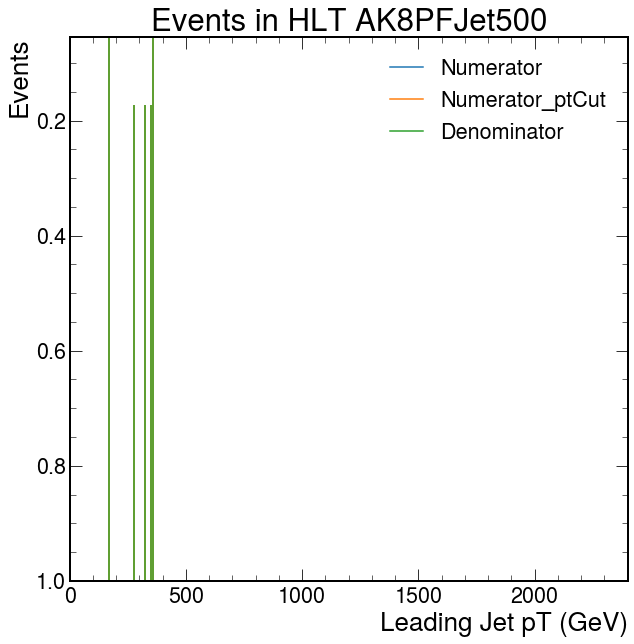

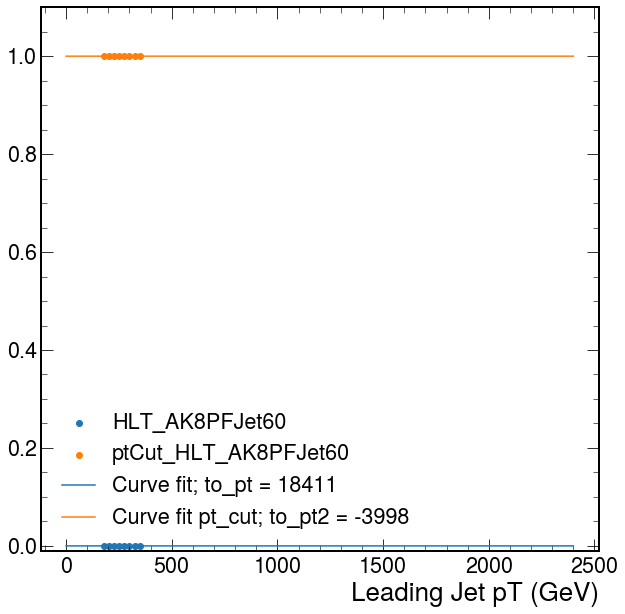

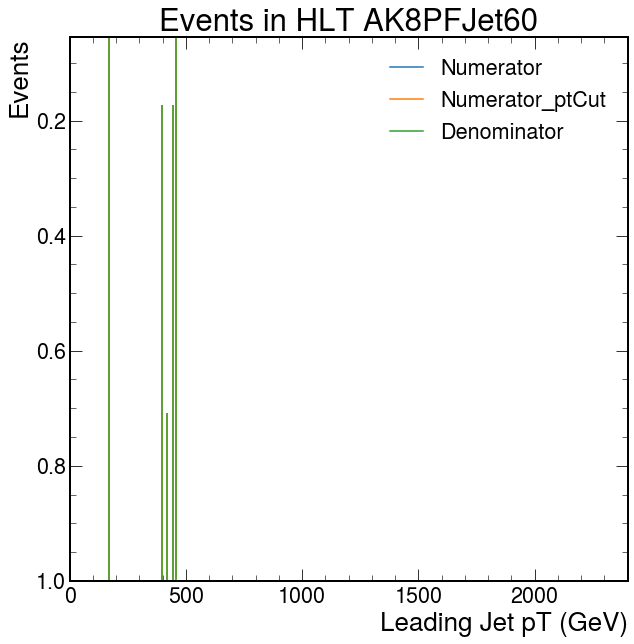

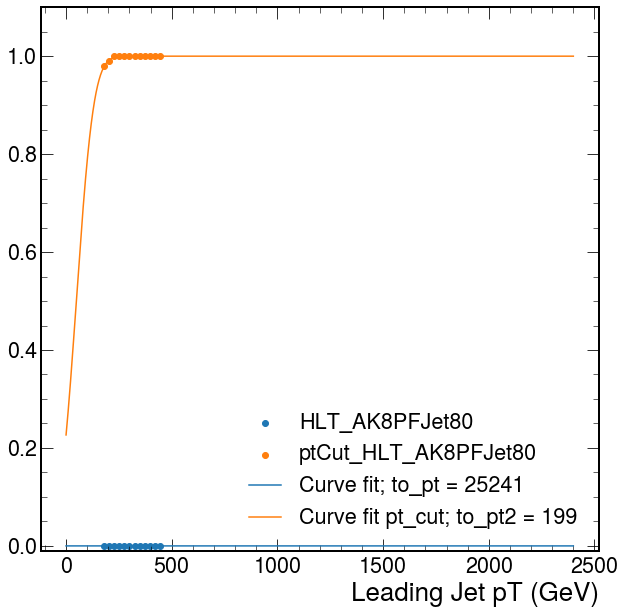

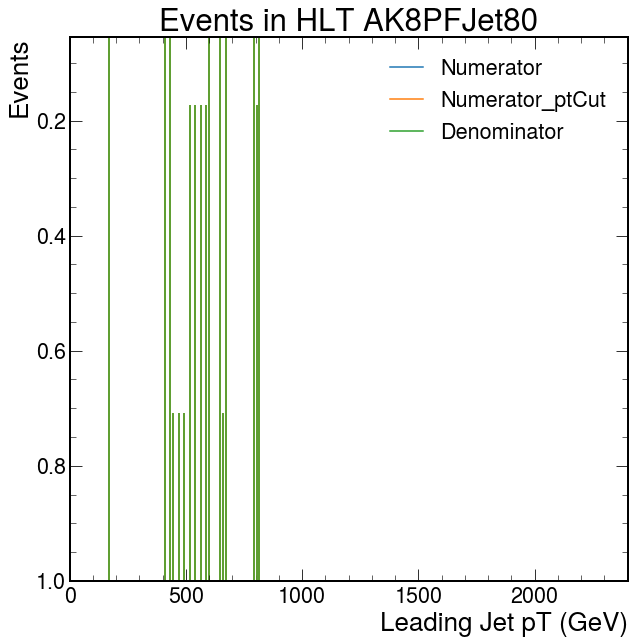

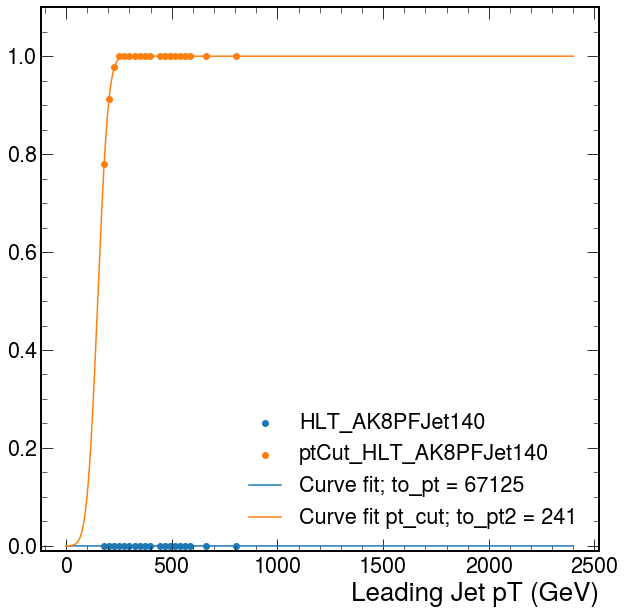

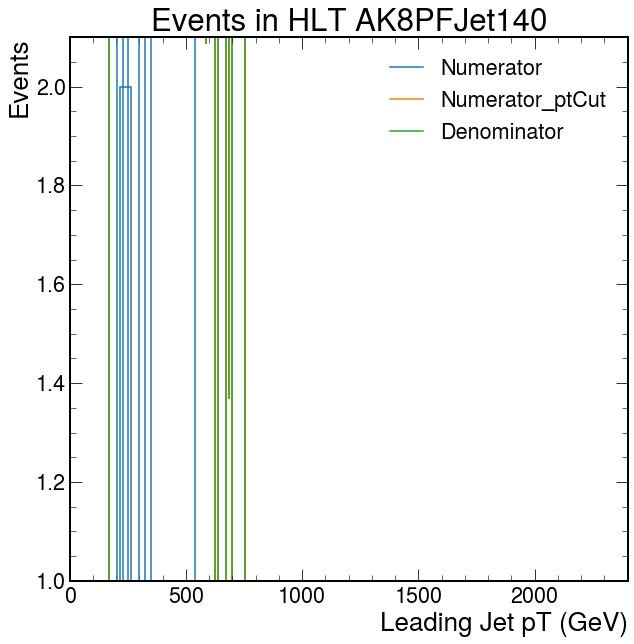

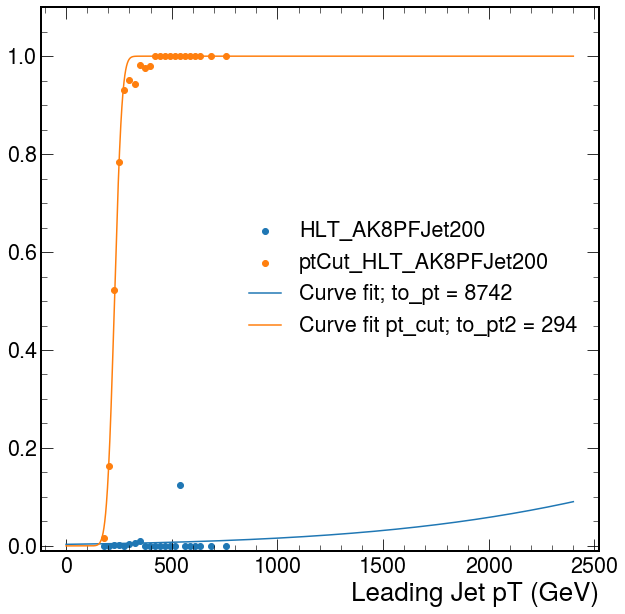

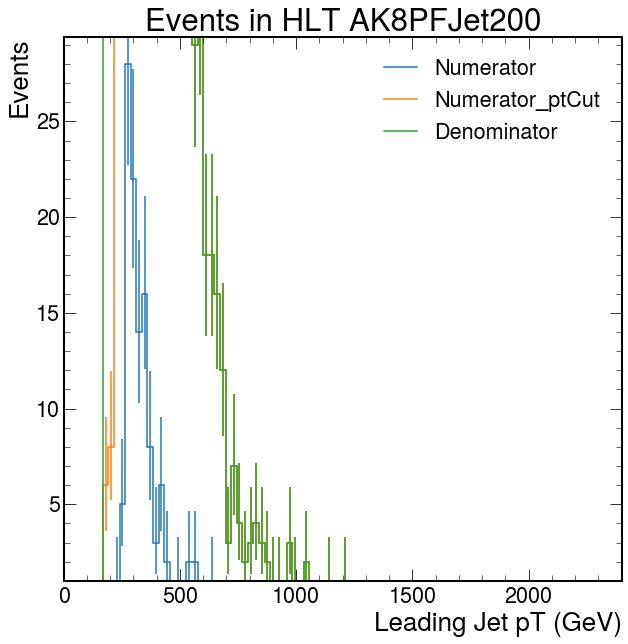

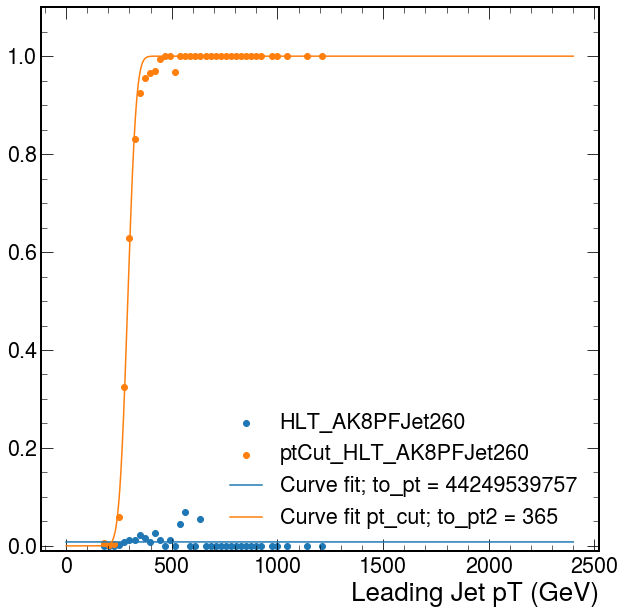

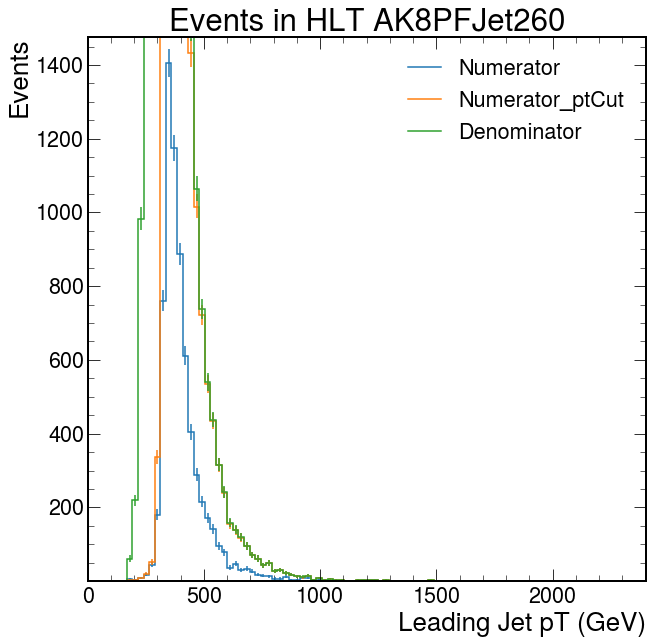

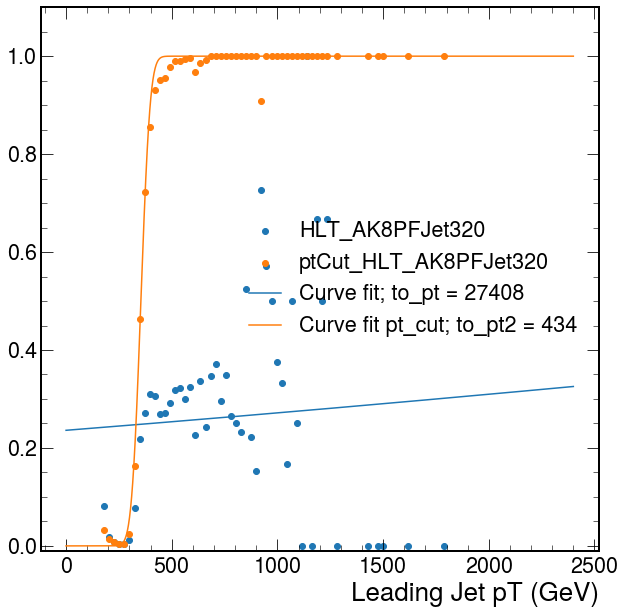

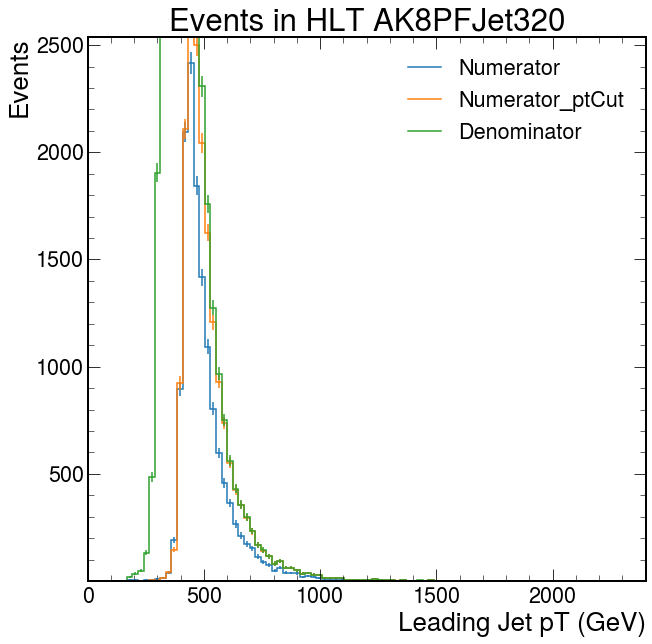

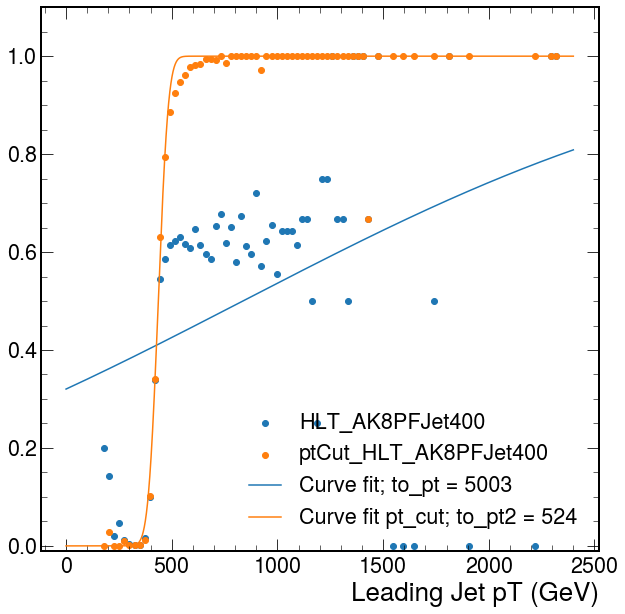

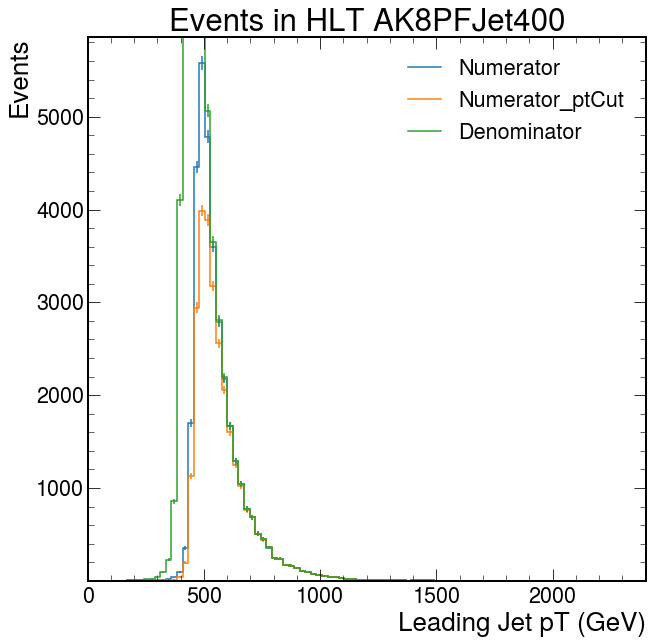

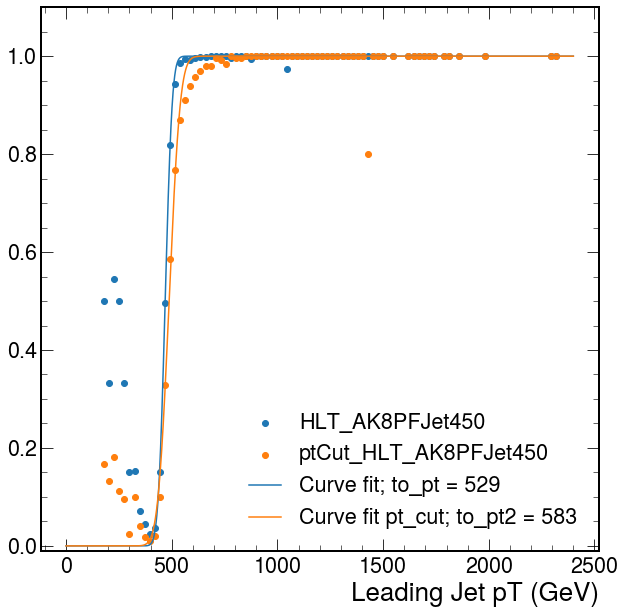

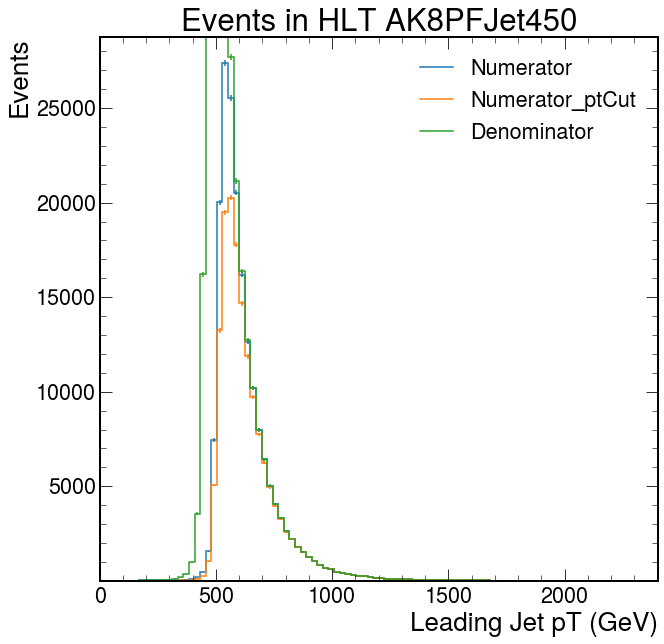

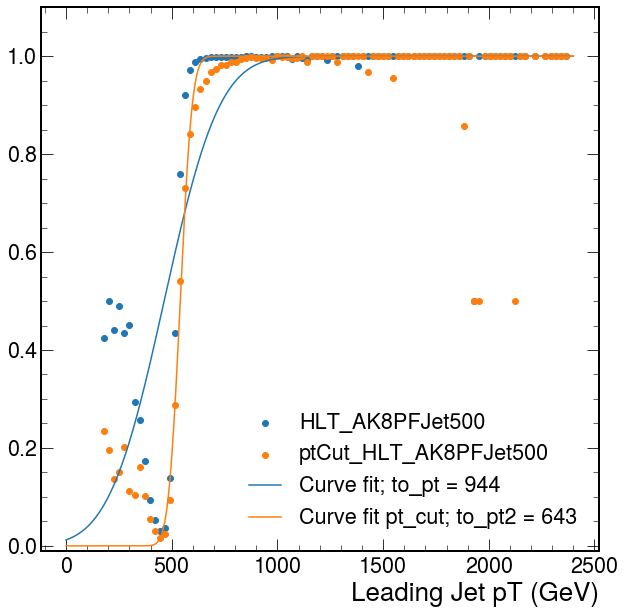

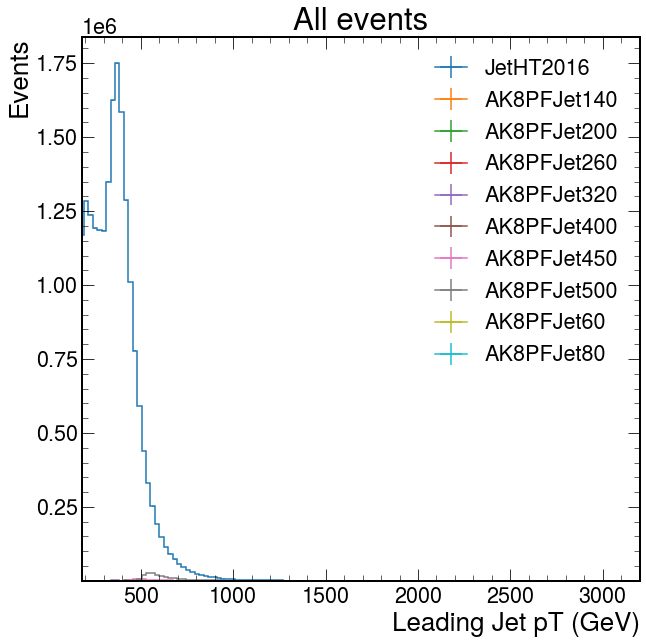

In [13]:
HLT = 'AK8PFJet'
result = util.load('coffeaOutput/DiJet_2016_JetHT_Testing_AK8prescale_result.coffea')
turnOnPts, turnOnPts_ptCut = plot_turnOn(result, HLT)
print(turnOnPts)

In [14]:
print(turnOnPts_ptCut)
turnOnPts_2016_JetHT = {'AK8PFJet60': 0, 
                        'AK8PFJet80': 199., 
                        'AK8PFJet140': 242.,
                        'AK8PFJet200': 294., 
                        'AK8PFJet260': 365., 
                        'AK8PFJet320': 434.,
                        'AK8PFJet400': 524.,
                        'AK8PFJet450': 583.,
                        'AK8PFJet500': 643.}
turnOnPts_2017_JetHT = {'AK8PFJet60': 0, 
                        'AK8PFJet80': 160.,
                        'AK8PFJet140': 261.,
                        'AK8PFJet200': 308.,
                        'AK8PFJet260': 380.,
                        'AK8PFJet320': 453.,
                        'AK8PFJet400': 547., 
                        'AK8PFJet450': 606.,
                        'AK8PFJet500': 670.,
                        'AK8PFJet550': 731.}
turnOnPts_2018_JetHT = {'AK8PFJet60': 0, 
                  'AK8PFJet80': 164., 
                  'AK8PFJet140': 252.,
                  'AK8PFJet200': 305.,
                  'AK8PFJet260': 379.,
                  'AK8PFJet320': 451.,
                  'AK8PFJet400': 544.,
                  'AK8PFJet450': 609.,
                  'AK8PFJet500': 668.,
                  'AK8PFJet550': 727.}



{'AK8PFJet60': -3998.3181463946466, 'AK8PFJet80': 199.10664378282192, 'AK8PFJet140': 241.4976601551196, 'AK8PFJet200': 293.77165223603987, 'AK8PFJet260': 365.0363045161106, 'AK8PFJet320': 433.7361644408849, 'AK8PFJet400': 523.5393783125293, 'AK8PFJet450': 582.7079941847162, 'AK8PFJet500': 643.2270990152708}


In [10]:
# HLT = "AK8PFJet"
# result = util.load('coffeaOutput/DiJet_2018_QCD_AK8prescale_result.coffea')
# turnOnPts = plot_turnOn(result['hist_trigEff'], result['hist_trigRef'], HLT)
# print(turnOnPts)

In [ ]:
#TO DO: if statement to add prefix "HLT_" if using uproot --> 
###now switch to just coffea
#### THESE ARE NOT FINAL VALUES - NEED TO MAKE TURNON PLOTS
year = 2018
trigger = 'AK8PFJet'
if year == 2016:
    # HLT_paths = ['AK8PFJet40', 'AK8PFJet60', 'AK8PFJet80', 'AK8PFJet140', 'AK8PFJet200', 'AK8PFJet260', 'AK8PFJet320', 'AK8PFJet400', 'AK8PFJet450', 'AK8PFJet500']
    trigThresh = [40, 60, 80, 140, 200, 260, 320, 400, 450, 500]
    HLT_paths = [trigger + str(i) for i in trigThresh]
elif year == 2017:
    # HLT_paths = ['AK8PFJet40', 'AK8PFJet60', 'AK8PFJet80', 'AK8PFJet140', 'AK8PFJet200', 'AK8PFJet260', 'AK8PFJet320', 'AK8PFJet400', 'AK8PFJet450', 'AK8PFJet500', 'AK8PFJet550']
    trigThresh = [40, 60, 80, 140, 200, 260, 320, 400, 450, 500, 550]
    HLT_paths = [trigger + str(i) for i in trigThresh]
elif year == 2018:
    # HLT_paths = ['AK8PFJet15', 'AK8PFJet25', 'AK8PFJet40', 'AK8PFJet60', 'AK8PFJet80', 'AK8PFJet140', 'AK8PFJet200', 'AK8PFJet260', 'AK8PFJet320', 'AK8PFJet400', 'AK8PFJet450', 'AK8PFJet500', 'AK8PFJet550']
    trigThresh = [15, 25, 40, 60, 80, 140, 200, 260, 320, 400, 450, 500, 550]
    HLT_paths = [trigger + str(i) for i in trigThresh]
prescale_2016 = {
    'AK8PFJet40'  : 136006.59,
    'AK8PFJet60'  : 50007.75,
    'AK8PFJet80'  : 13163.18,
    'AK8PFJet140' : 1501.12,
    'AK8PFJet200' : 349.82,
    'AK8PFJet260' : 61.17,
    'AK8PFJet320' : 20.49,
    'AK8PFJet400' : 6.99,
    'AK8PFJet450' : 1.00,
    'AK8PFJet500' : 1.00
            }
tot_lumi_2016 = 36.31
prescale_2017 = {
    'PFJet40'  : 86061.17, 
    'PFJet60'  : 36420.75,    
    'PFJet80'  : 9621.74,    
    'PFJet140' : 1040.40,  
    'PFJet200' : 189.54,      
    'PFJet260' : 74.73,     
    'PFJet320' : 29.49,      
    'PFJet400' : 9.85,       
    'PFJet450' : 3.97,       
    'PFJet500' : 1.00,       
    'PFJet550' : 1.00,
}
tot_lumi_2017 = 41.48
prescale_2018 = {
    'PFJet15'  : 318346231.66,
    'PFJet25'  : 318346231.66,
    'PFJet40'  : 248642.75,
    'PFJet60'  : 74330.16,  
    'PFJet80'  : 11616.52,   
    'PFJet140' : 1231.88,   
    'PFJet200' : 286.14,    
    'PFJet260' : 125.78,     
    'PFJet320' : 32.66,     
    'PFJet400' : 15.83,      
    'PFJet450' : 7.96,      
    'PFJet500' : 1.00,       
    'PFJet550' : 1.00,   
}
tot_lumi_2018 = 59.83
print(HLT_paths)

In [ ]:
#### Sal pseudocode
# for path in prescale_2016: 
#     thesum = np.sum(events[path].array())
#     print("%20s : %10d" % (path, thesum) )

# DEPRECATED APPLY PRESCALES CODE -- moving to trigger processor
%matplotlib inline
import matplotlib.pyplot as plt

HLT_masks = { }
HLT_masks_noDoubles = {}
HLT_masks_ptBinned = {}
print(pt_thresh_2016.values())
pt_bins_2016 = [0., 140.0, 200.0, 260.0, 350.0, 460.0, 550.0, 650.0, 760.0, 760.0, 3000.]
#current binning is lazy scatter
prescale_hist_16 = hist.Hist("Events",
                             hist.Cat("dataset", "Dataset"),
                             hist.Cat("HLT_cat", ""),
                             hist.Bin("pt", "Jet pT (GeV)", 500, 0., 3000.),
                 )
prescale_hist_noDoubles_16 = hist.Hist("Events",
                             hist.Cat("dataset", "Dataset"),
                             hist.Cat("HLT_cat", "HLT_PFJet_category"),
                             hist.Bin("pt", "Jet pT (GeV)", 500, 0., 3000.),
                 )
prescale_hist_ptBinned_16 = hist.Hist("Events",
                             hist.Cat("dataset", "Dataset"),
                             hist.Cat("HLT_cat", "HLT_PFJet_category"),
                             hist.Bin("pt", "Jet pT (GeV)", 500, 0., 3000.),
                 )


##### make HLT_masks dictionary
for i in np.arange(len(HLT_paths))[::-1]:
    path = HLT_paths[i]
#     HLT_masks[path] = uprootevents[path].array()
    HLT_masks[path] = events.HLT[path]
#     print(np.sum(HLT_masks[path]))  
leadingjets = events.FatJet[:,0]

# change to pythonic --> use np.digitize
for i in np.arange(len(HLT_paths))[::-1]:
    print(i)
    path = HLT_paths[i]
    pt0 = events.FatJet[:,0].pt
#     print(pt0) #leading pt of each jet
    if i > 0 and prescale_2016[path] != 1.0:
            print(pt_thresh_2016[HLT_paths[i-1]])
            print((pt_thresh_2016[HLT_paths[i-1]] <= pt0) & (pt0 < pt_thresh_2016[path]))
            print(events.HLT[path])
            HLT_masks_noDoubles[path] = (events.HLT[path] & (pt_thresh_2016[HLT_paths[i-1]] <= pt0) & (pt0 < pt_thresh_2016[path]))
            print('bin edges for ', path, ' are ', pt_thresh_2016[HLT_paths[i-1]], ' and ', pt_thresh_2016[path])
    elif i > 0 and prescale_2016[path] == 1.0:
        print('bin edge for ', path, ' is ', pt_thresh_2016[HLT_paths[i-1]])
        HLT_masks_noDoubles[path] = (events.HLT[path] & (pt_thresh_2016[HLT_paths[i-1]] <= pt0))
    elif i == 0:
        print('bin edge for ', path, ' is ', pt_thresh_2016[path])
        HLT_masks_noDoubles[path] = (events.HLT[path] & ak.all(pt0 < pt_thresh_2016[path], axis = -1))
    else:
        break
#     print(np.sum(HLT_masks_noDoubles[path]))

##### hardcode get rid of doubles
# HLT_masks_noDoubles['PFJet500'] = HLT_masks['PFJet500']
# HLT_masks_noDoubles['PFJet450'] = HLT_masks['PFJet450'] & ~HLT_masks['PFJet500']
# HLT_masks_noDoubles['PFJet400'] = HLT_masks['PFJet400'] & ~HLT_masks['PFJet450'] & ~HLT_masks['PFJet500']
# HLT_masks_noDoubles['PFJet320'] = HLT_masks['PFJet320'] & ~HLT_masks['PFJet400'] & ~HLT_masks['PFJet450'] & ~HLT_masks['HLT_PFJet500']
# HLT_masks_noDoubles['PFJet260'] = HLT_masks['PFJet260'] & ~HLT_masks['PFJet320'] & ~HLT_masks['PFJet400'] & ~HLT_masks['HLT_PFJet450'] & ~HLT_masks['HLT_PFJet500']
# HLT_masks_noDoubles['PFJet200'] = HLT_masks['PFJet200'] & ~HLT_masks['PFJet260'] & ~HLT_masks['PFJet320'] & ~HLT_masks['HLT_PFJet400'] & ~HLT_masks['HLT_PFJet450'] & ~HLT_masks['HLT_PFJet500']
# HLT_masks_noDoubles['PFJet140'] = HLT_masks['PFJet140'] & ~HLT_masks['PFJet200'] & ~HLT_masks['PFJet260'] & ~HLT_masks['HLT_PFJet320'] & ~HLT_masks['HLT_PFJet400'] & ~HLT_masks['HLT_PFJet450'] & ~HLT_masks['HLT_PFJet500']
# HLT_masks_noDoubles['PFJet80'] = HLT_masks['PFJet80'] & ~HLT_masks['PFJet140'] & ~HLT_masks['PFJet200'] & ~HLT_masks['HLT_PFJet260'] & ~HLT_masks['HLT_PFJet320'] & ~HLT_masks['HLT_PFJet400'] & ~HLT_masks['HLT_PFJet450'] & ~HLT_masks['HLT_PFJet500']
# HLT_masks_noDoubles['PFJet60'] = HLT_masks['PFJet60'] & ~HLT_masks['PFJet80'] & ~HLT_masks['HLT_PFJet140'] & ~HLT_masks['HLT_PFJet200'] & ~HLT_masks['HLT_PFJet260'] & ~HLT_masks['HLT_PFJet320'] & ~HLT_masks['HLT_PFJet400'] & ~HLT_masks['HLT_PFJet450'] & ~HLT_masks['HLT_PFJet500']
# HLT_masks_noDoubles['PFJet40'] = HLT_masks['PFJet40'] & ~HLT_masks['PFJet60'] & ~HLT_masks['HLT_PFJet80'] & ~HLT_masks['HLT_PFJet140'] & ~HLT_masks['HLT_PFJet200'] & ~HLT_masks['HLT_PFJet260'] & ~HLT_masks['HLT_PFJet320'] & ~HLT_masks['HLT_PFJet400'] & ~HLT_masks['HLT_PFJet450'] & ~HLT_masks['HLT_PFJet500']
for path in HLT_masks:
    print("# of ", path, " events with doubles ", np.sum(HLT_masks[path]), "\n")
    print("# of ", path, " events WITHOUT doubles", np.sum(HLT_masks_noDoubles[path]), "\n")
    print("# of ", path, " events within pt bins", np.sum(HLT_masks_noDoubles[path]), "\n")
#### apply masks and fill hists
for path in HLT_paths[::-1]:
    if path in events.HLT.fields:
        fatjets = leadingjets[events.HLT[path]]
        fatjets_noDoubles = leadingjets[HLT_masks_noDoubles[path]]
        fatjets_ptBinned = leadingjets[HLT_masks_noDoubles[path]]
        prescale_hist_16.fill(dataset = "JetHT_2016", HLT_cat = path, pt = fatjets.pt)
        prescale_hist_noDoubles_16.fill(dataset = "JetHT_2016", HLT_cat = path, pt = fatjets_noDoubles.pt)
        prescale_hist_ptBinned_16.fill(dataset = "JetHT_2016", HLT_cat = path, pt = fatjets_ptBinned.pt)    
    else:
        print(path, ' not in collection, moving to next path -- years are likely mismatched')
        
plt.rcParams['figure.facecolor']='white'
plt.rcParams["figure.figsize"] = (15,10)
fig, axs = plt.subplots(2, 2)

print("Check for none values", ak.any(ak.is_none(fatjets.pt, axis = -1)))
        
# print(np.isnan(prescale_hist_16))
    
hist.plot1d(prescale_hist_16.sum('dataset'), ax = axs[0,0], overlay='HLT_cat')
axs[0,0].set_yscale('log')
axs[0,0].set_ylim([1.0e-1, 5.0e4])
axs[0,0].set_title('Events sorted by HLT')

prescale_hist_16.scale(prescale_2016, axis = 'HLT_cat')

hist.plot1d(prescale_hist_16.sum('dataset'), ax = axs[0,1], overlay='HLT_cat')
axs[0,1].set_yscale('log')
axs[0,1].set_ylim([1.0e-1, 6.0e7])
axs[0,1].set_title('Events sorted by HLT w/ prescale applied')

hist.plot1d(prescale_hist_noDoubles_16.sum('dataset'), ax = axs[1,0], overlay='HLT_cat')
axs[1,0].set_yscale('log')
axs[1,0].set_ylim([1.0e-1, 5.0e4])
axs[1,0].set_title('Doubles removed')

prescale_hist_noDoubles_16.scale(prescale_2016, axis = 'HLT_cat')

hist.plot1d(prescale_hist_noDoubles_16.sum('dataset'), ax = axs[1,1], overlay='HLT_cat')
axs[1,1].set_yscale('log')
axs[1,1].set_ylim([1.0e-1, 6.0e7])
axs[1,1].set_title('Doubles removed w/ prescale applied')

hist.plot1d(prescale_hist_noDoubles_16.sum('dataset'), ax = axs[1,0], overlay='HLT_cat')
axs[1,0].set_yscale('log')
axs[1,0].set_ylim([1.0e-1, 5.0e7])
axs[1,0].set_title('Doubles removed')

prescale_hist_noDoubles_16.scale(prescale_2016, axis = 'HLT_cat')

hist.plot1d(prescale_hist_noDoubles_16.sum('dataset'), ax = axs[1,1], overlay='HLT_cat')
axs[1,1].set_yscale('log')
axs[1,1].set_ylim([1.0e-1, 6.0e11])
axs[1,1].set_title('Doubles removed w/ prescale applied')

In [ ]:
# HLT_masks_noDoubles['PFJet500'] = HLT_masks['PFJet500']
# HLT_masks_noDoubles['PFJet450'] = HLT_masks['PFJet450'] & ~HLT_masks['PFJet500']
# HLT_masks_noDoubles['PFJet400'] = HLT_masks['PFJet400'] & ~HLT_masks['PFJet450'] & ~HLT_masks['PFJet500']
# HLT_masks_noDoubles['PFJet320'] = HLT_masks['PFJet320'] & ~HLT_masks['PFJet400'] & ~HLT_masks['PFJet450'] & ~HLT_masks['HLT_PFJet500']
# HLT_masks_noDoubles['PFJet260'] = HLT_masks['PFJet260'] & ~HLT_masks['PFJet320'] & ~HLT_masks['PFJet400'] & ~HLT_masks['HLT_PFJet450'] & ~HLT_masks['HLT_PFJet500']
# HLT_masks_noDoubles['PFJet200'] = HLT_masks['PFJet200'] & ~HLT_masks['PFJet260'] & ~HLT_masks['PFJet320'] & ~HLT_masks['HLT_PFJet400'] & ~HLT_masks['HLT_PFJet450'] & ~HLT_masks['HLT_PFJet500']
# HLT_masks_noDoubles['PFJet140'] = HLT_masks['PFJet140'] & ~HLT_masks['PFJet200'] & ~HLT_masks['PFJet260'] & ~HLT_masks['HLT_PFJet320'] & ~HLT_masks['HLT_PFJet400'] & ~HLT_masks['HLT_PFJet450'] & ~HLT_masks['HLT_PFJet500']
# HLT_masks_noDoubles['PFJet80'] = HLT_masks['PFJet80'] & ~HLT_masks['PFJet140'] & ~HLT_masks['PFJet200'] & ~HLT_masks['HLT_PFJet260'] & ~HLT_masks['HLT_PFJet320'] & ~HLT_masks['HLT_PFJet400'] & ~HLT_masks['HLT_PFJet450'] & ~HLT_masks['HLT_PFJet500']
# HLT_masks_noDoubles['PFJet60'] = HLT_masks['PFJet60'] & ~HLT_masks['PFJet80'] & ~HLT_masks['HLT_PFJet140'] & ~HLT_masks['HLT_PFJet200'] & ~HLT_masks['HLT_PFJet260'] & ~HLT_masks['HLT_PFJet320'] & ~HLT_masks['HLT_PFJet400'] & ~HLT_masks['HLT_PFJet450'] & ~HLT_masks['HLT_PFJet500']
# HLT_masks_noDoubles['PFJet40'] = HLT_masks['PFJet40'] & ~HLT_masks['PFJet60'] & ~HLT_masks['HLT_PFJet80'] & ~HLT_masks['HLT_PFJet140'] & ~HLT_masks['HLT_PFJet200'] & ~HLT_masks['HLT_PFJet260'] & ~HLT_masks['HLT_PFJet320'] & ~HLT_masks['HLT_PFJet400'] & ~HLT_masks['HLT_PFJet450'] & ~HLT_masks['HLT_PFJet500']
